# **Exploring Machine Learning Regression Techniques to Predict Implied Stock Volatility Based on Strike Price and Time Until Expiration**

By Pranav Narala, Patrick Oglesby, Maruthi Vemula, Alan Elrod, Mouktik Isukapalli

In [ ]:
%%capture
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 5.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
import yfinance as yf
import pandas as pd

# **Data Collection**

We collected options data using Polygon.
Although Polygon did not have historical implied volatility data for options, they had many more options listed than Yahoo Finance.

We used the expiration date and the last time the option was updated to calculate the days until the option expired.

Addionally, we used the strike price and current price of the underlying security to calculate the ratio of the strike price to the security price, or how much the option expected the stock to shift in value.


In [ ]:
import numpy as np
from datetime import datetime
import pytz
from math import trunc

In [ ]:
# list of tickers that we're collecting data on.

tickers = ["LMT", "RTX", "BA", "NOC", "GD", "DRS", "AAPL", "T", "GOOG", "MSFT",
           "META", "CSCO", "ADM", "PEP", "TSN", "MDLZ", "KO", "GIS", "UNH",
           "CI", "CVS", "CAH", "ABC", "MCK", "WMT", "COST", "HD", "TGT", 
           "AMZN", "BBY", "BRK-B", "JPM", "BAC", "WFC", "C", "BLK"]

# All of the S&P 500 Stocks, as an option for a larger dataset.
tickers_full = ['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'BRK-B', 'XOM', 'UNH',
             'JNJ', 'V', 'NVDA', 'JPM', 'WMT', 'TSLA', 'META', 'MA', 'PG', 
             'CVX', 'LLY', 'HD', 'MRK', 'BAC', 'ABBV', 'PFE', 'KO', 'AVGO',
             'PEP', 'ORCL', 'TMO', 'COST', 'CSCO', 'NKE', 'DHR', 'MCD', 'ABT',
             'ACN', 'TMUS', 'DIS', 'VZ', 'NEE', 'CMCSA', 'WFC', 'LIN', 'TXN', 
             'ADBE', 'UPS', 'PM', 'MS', 'BMY', 'SCHW', 'COP', 'CRM', 'RTX', 
             'NFLX', 'HON', 'AMGN', 'T', 'QCOM', 'CAT', 'UNP', 'IBM', 'LOW', 
             'DE', 'BA', 'GS', 'INTC', 'SPGI', 'SBUX', 'LMT', 'CVS', 'AXP', 
             'ELV', 'AMD', 'BLK', 'PLD', 'INTU', 'AMT', 'GILD', 'MDT', 'ADP',
             'SYK', 'C', 'CI', 'TJX', 'CB', 'EL', 'AMAT', 'MDLZ', 'PYPL', 
             'ISRG', 'BKNG', 'MMC', 'GE', 'ADI', 'NOW', 'SLB', 'MO', 'DUK', 
             'PGR', 'EOG', 'SO', 'REGN', 'VRTX', 'NOC', 'ZTS', 'TGT', 'BDX', 
             'MRNA', 'HCA', 'MMM', 'ITW', 'USB', 'APD', 'CSX', 'PNC', 'GD', 
             'EQIX', 'BSX', 'ETN', 'CCI', 'AON', 'FISV', 'FCX', 'CL', 'LRCX', 
             'CME', 'SHW', 'WM', 'TFC', 'HUM', 'MU', 'ICE', 'ATVI', 'CHTR', 
             'OXY', 'KLAC', 'NSC', 'EMR', 'PXD', 'MCO', 'MPC', 'MET', 'GM', 
             'MCK', 'F', 'D', 'MNST', 'VLO', 'PSA', 'DG', 'KHC', 'SNPS', 'ORLY',
             'MAR', 'SRE', 'KDP', 'AEP', 'GIS', 'PSX', 'FDX', 'APH', 'EW', 
             'ADM', 'ROP', 'AIG', 'JCI', 'HES', 'A', 'CDNS', 'KMB', 'HSY', 
             'CTAS', 'TRV', 'CTVA', 'AFL', 'AZO', 'CNC', 'MSI', 'NXPI', 'ECL', 
             'PAYX', 'ADSK', 'EXC', 'KMI', 'NEM', 'CMG', 'DVN', 'O', 'TT', 
             'BIIB', 'DXCM', 'MCHP', 'SPG', 'DOW', 'STZ', 'AJG', 'FIS', 'ROST', 
             'LVS', 'IQV', 'SYY', 'PH', 'MSCI', 'WMB', 'NUE', 'TEL', 'XEL', 
             'RSG', 'BK', 'IDXX', 'COF', 'HAL', 'LHX', 'CARR', 'FTNT', 'DD', 
             'PRU', 'TDG', 'HLT', 'ALL', 'YUM', 'ANET', 'CMI', 'PCAR', 'AMP', 
             'EA', 'ED', 'ODFL', 'OTIS', 'MTD', 'WELL', 'ABC', 'CTSH', 'AME', 
             'SBAC', 'DHI', 'ENPH', 'DLTR', 'VICI', 'KR', 'CSGP', 'ROK', 'WBD',
             'KEYS', 'PCG', 'OKE', 'WBA', 'BKR', 'BF.B', 'RMD', 'PEG', 'NDAQ', 
             'PPG', 'GLW', 'DLR', 'WEC', 'LYB', 'ILMN', 'STT', 'ES', 'IFF', 
             'GPN', 'AWK', 'DFS', 'GWW', 'VRSK', 'ALB', 'LEN', 'ON', 'FAST', 
             'HPQ', 'WTW', 'APTV', 'CEG', 'URI', 'CBRE', 'TROW', 'IT', 'EFX', 
             'CDW', 'EIX', 'ZBH', 'MTB', 'ARE', 'FANG', 'HRL', 'DAL', 'EBAY', 
             'ULTA', 'FE', 'RJF', 'TSCO', 'HIG', 'VMC', 'FITB', 'K', 'GPC', 
             'AVB', 'FTV', 'WY', 'ACGL', 'TSN', 'EQR', 'IR', 'AEE', 'DTE', 
             'FRC', 'BAX', 'PPL', 'VRSN', 'LH', 'LUV', 'ANSS', 'MLM', 'ETR', 
             'MKC', 'PFG', 'HBAN', 'PWR', 'XYL', 'HPE', 'RF', 'EXR', 'CFG', 
             'NTRS', 'CAH', 'DOV', 'CTRA', 'STE', 'WAT', 'VTR', 'CHD', 'HOLX', 
             'EPAM', 'CNP', 'TDY', 'WRB', 'STLD', 'INVH', 'CAG', 'BBY', 'FSLR', 
             'WAB', 'GRMN', 'MPWR', 'CMS', 'JBHT', 'MAA', 'AES', 'ROL', 'ALGN', 
             'WST', 'PAYC', 'AMCR', 'DRI', 'BALL', 'INCY', 'IEX', 'CLX', 'EXPD',
             'TTWO', 'MOH', 'BRO', 'MRO', 'SEDG', 'COO', 'OMC', 'KEY', 'TRGP', 
             'BR', 'FOX', 'FOXA', 'CINF', 'CF', 'LYV', 'DGX', 'HWM', 'UAL', 
             'PKI', 'SJM', 'ETSY', 'ATO', 'CPB', 'FMC', 'SWKS', 'J', 'MOS', 
             'RCL', 'FDS', 'NVR', 'AVY', 'EXPE', 'LKQ', 'PTC', 'IRM', 'SYF', 
             'ZBRA', 'SIVB', 'TER', 'MGM', 'BEN', 'TXT', 'CPRT', 'PEAK', 'EVRG',
             'APA', 'FLT', 'GEN', 'ESS', 'L', 'VTRS', 'LNT', 'LW', 'IPG', 'KIM',
             'AKAM', 'NDSN', 'NTAP', 'RE', 'POOL', 'LDOS', 'IP', 'TRMB', 'PARA',
             'JKHY', 'BIO', 'SNA', 'CE', 'TYL', 'UDR', 'CBOE', 'MTCH', 'EQT', 
             'SWK', 'CPT', 'PKG', 'HST', 'MKTX', 'STX', 'WDC', 'DPZ', 'VFC', 
             'CRL', 'GL', 'MAS', 'PHM', 'CCL', 'REG', 'NI', 'NWS', 'NWSA', 
             'TFX', 'WYNN', 'BXP', 'CHRW', 'EMN', 'AAL', 'HSIC', 'UHS', 'KMX',
             'BBWI', 'BWA', 'TPR', 'JNPR', 'CDAY', 'CZR', 'QRVO', 'ALLE', 'WRK',
             'AOS', 'AAP', 'HII', 'HAS', 'CMA', 'IVZ', 'FRT', 'FFIV', 'CTLT', 
             'PNW', 'WHR', 'RHI', 'PNR', 'RL', 'DISH', 'OGN', 'SEE', 'XRAY', 
             'ZION', 'MHK', 'NRG', 'GNRC', 'SBNY', 'DVA', 'AIZ', 'DXC', 'NCLH', 
             'ALK', 'NWL', 'LUMN', 'LNC', 'TECH', 'TAP', 'GEHC']

Data Collection - Yahoo Finance API

In [ ]:
tickers_list = []
for i in tickers:
    ticker = yf.Ticker(i)
    tickers_list += [ticker]

# Turns each ticker in the list of tickers selected from above into a yfinance
# ticker object. This allows us to collect data on them later on.

In [ ]:
# Gets training data. Method 1

size_of_dataset = 20000
# Change this value to vary the maximum size of the dataset.

values_array = np.empty([size_of_dataset, 3])
index = 0

# The loop below collects data on all of the tickers in the list created above.
# On average, prepares data on around 1250 options a minute.

for ticker in tickers_list:
    ticker_array = [] # Where the data is stored
    for date in ticker.options:
        options_frame = ticker.option_chain(date).calls # Gets all call options
        if (len(options_frame) > 0): # Checks to make sure there are options for that date
            expirationArray = [pytz.utc.localize(datetime.strptime(date, "%Y-%m-%d"))] * len(options_frame)
            # Creates an array containing the expiration date, to be appended to the dataframe. Converts string to date.
            options_frame.insert(2, "expirationDate", expirationArray, True) # appends the array.
            timeDifferenceArray = [] # Will hold the time difference between the last trade date and expiration date.
            for i in ((options_frame.expirationDate - options_frame.lastTradeDate)): # measures time in days
                timeDifferenceArray += [i.total_seconds()/(60*60*24)]
            
            percentChangeArray = []
            for i in ((options_frame.strike - options_frame.lastPrice)/options_frame.lastPrice):
                percentChangeArray += [i]
                
            options_frame.insert(3, "timeDifference", timeDifferenceArray, True)
            options_frame.insert(4, "percentageChange", percentChangeArray, True)
            # Idea for later: strike price relative to current ticker price would probably have better results
            input_vals = [list(a) for a in zip(options_frame.percentageChange.values.tolist(),
                                               options_frame.timeDifference.values.tolist(), 
                                               options_frame.impliedVolatility.values.tolist())]
            # Concatenates desired values into a 2d list
            ticker_array += input_vals # stores all the 2d lists for a ticker
        
    ticker_array = np.array(ticker_array) # turns lists into an nparray
    filter_array = []
    for num in range(len(ticker_array)): # Filters out the values below
        if ticker_array[num][2] > 0.01 and ticker_array [num][2] <= 5 and abs(ticker_array[num][0] < 5): # Keeps all values with implied volatility above 1% and below 500%
            filter_array += [True]
        else:
            filter_array += [False]
    ticker_array = (ticker_array[filter_array])
    for item in ticker_array:
        if index < size_of_dataset:
            values_array[index] = item
            index += 1
        else:
          break
    if index >= size_of_dataset:
      break

values_array = values_array[:index]
# values_array is the variable that stores the results of this code.

Data Collection - Polygon API

In [ ]:
import requests as req

api_key = "ZKwLbp0tGTe4I0MLTKnL02ixsGGwKOHy"
# Should be set equal to your Polygon API key.

In [ ]:
# Gets Training Data (Polygon API)

max_size = 20000
# Change this to vary the maximum amount of options that data is collected on.

options_name_list = []

# Change this string if you would like to add different conditions to the API Request
# Documentation: https://polygon.io/docs/options/get_v3_reference_options_contracts
optionsString = "&contract_type=call&sort=expiration_date&order=desc&limit=1000"

for ticker in tickers: # gets a list of current options for each ticker with the max size listed above
  res = req.get("https://api.polygon.io/v3/reference/options/contracts?apiKey=" + api_key + "&underlying_ticker=" + ticker + optionsString)
  options_name_list += [[ticker, i["ticker"]] for i in res.json()["results"]] # Puts each option name, as well as it's underlying ticker, into a list item.
  if len(options_name_list) > max_size: # Constricts list length to the maximum size
    options_name_list = options_name_list[:max_size]
    break
print(len(options_name_list))

19207


In [ ]:
# Function to get data for an option name
# This function prepares data for around 225 options per minute, due to the slow nature of individual API calls.

def get_polygon_data(option_name):
  ticker = option_name[0] # The underlying ticker
  option = option_name[1] # The option ticker
  res = req.get("https://api.polygon.io/v3/snapshot/options/" + ticker + "/" + option + "?apiKey=" + api_key).json() # Makes API request
  try:
    res = res['results']
    strike_price = res['details']['strike_price']
    expiration_date = datetime.strptime(res['details']['expiration_date'], "%Y-%m-%d") # Converts the expiration date from a string to a datetime object
    current_date = datetime.fromtimestamp(res['day']['last_updated']/1000000000.0) # Converts the last-updated date from nanoseconds to seconds
    days_til_expiration = (expiration_date - current_date).days # Finds the time from last-updated to maturity in days. 
    volatility = res['implied_volatility']
    current_price = res['underlying_asset']['price']
    strike_ratio =  strike_price/current_price # Finds the ratio of the strike price to the current price.
    return [strike_ratio, days_til_expiration, volatility]
  except: # if data is missing, a placeholder is returned and no error is thrown.
    return 0

get_polygon_data(options_name_list[0])

[1.5946667257283973, 723, 0.2096670615994607]

In [ ]:
polygon_values_array = np.empty([len(options_name_list), 3])
offset = 0
for i in range(len(options_name_list)):
  values = get_polygon_data(options_name_list[i])
  if values == 0:
    offset += 1
  else:
    polygon_values_array[i - offset] = get_polygon_data(options_name_list[i])
  if i%100 == 0:
    print(i)

print(polygon_values_array)

In [ ]:
polygon_values_array = polygon_values_array[:len(options_name_list) - offset]
np.save("polygon_values", polygon_values_array)

In [ ]:
polygon_values = np.load("./polygon_values.npy")

filter_array = []

for i in polygon_values:
  if i[2] < 5 and i[2] > 0.01 and i[0] > 0 and i[1] > 0:
    filter_array += [True]
  else:
    filter_array += [False]

polygon_values = polygon_values[filter_array]
print(polygon_values)

[[1.58486454e+00 7.23000000e+02 2.10291910e-01]
 [1.54084053e+00 7.23000000e+02 2.13225549e-01]
 [1.49681651e+00 7.27000000e+02 2.09932599e-01]
 ...
 [9.33729725e-01 2.00000000e+00 5.96170537e-01]
 [9.26854926e-01 2.00000000e+00 6.48656779e-01]
 [8.99795501e-01 2.00000000e+00 5.99068379e-01]]


In [ ]:
# Training arrays 

x = []
y = []

for subarray in polygon_values:
    x += [subarray[0:2]]
    y += [subarray[2]]

x = np.array(x)
y = np.array(y)

training, test = x[:80,:], x[80:,:]

print(x, y)

[[  1.58486454 723.        ]
 [  1.54084053 723.        ]
 [  1.49681651 727.        ]
 ...
 [  0.93372973   2.        ]
 [  0.92685493   2.        ]
 [  0.8997955    2.        ]] [0.21029191 0.21322555 0.2099326  ... 0.59617054 0.64865678 0.59906838]


**Data Splitting**

To ensure data is set aside from the processed data to test the accuracy of the model after it trains on data, an 80-20 training-testing split was used.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

x_val = x_test[0:(len(x_test)//2)]
x_train = x_test[(len(x_test)//2):]
y_val = y_test[0:(len(y_test)//2)]
y_train = y_test[(len(y_test)//2):]

# **Implementing Machine Learning Regression Models**

Now that the data is processed, we are using a variety of different ML regression models to fit to the data and recognize trends within the dataset. Here are the main models being used:


*   Extra Trees Regressor
*   Ensemble Regressor
*   Random Forest Regressor
*   K Nearest Neighbors
*   Support Vector Machine
*   Decision Tree
*   Neural Network


**Neural Network**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense

nn = keras.models.Sequential([
    #Dense(32, input_shape = (2,), activation='swish'),
    Dense(32, input_shape = (2,), activation='tanh'),
    Dense(32, activation='sigmoid'),
    Dense(1, activation='tanh')
])

nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                96        
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nn.compile(optimizer="adam", loss= "mse", metrics="mean_absolute_percentage_error")
nn.fit(x=x_train, y=y_train, batch_size=50, epochs=150, validation_data=(x_val, y_val))

Epoch 1/150
29/29 [==============================] - 1s 9ms/step - loss: 0.0868 - mean_absolute_percentage_error: 41.6089 - val_loss: 0.0533 - val_mean_absolute_percentage_error: 46.0239
Epoch 2/150
29/29 [==============================] - 0s 4ms/step - loss: 0.0850 - mean_absolute_percentage_error: 40.9828 - val_loss: 0.0505 - val_mean_absolute_percentage_error: 37.9008
Epoch 3/150
29/29 [==============================] - 0s 5ms/step - loss: 0.0842 - mean_absolute_percentage_error: 40.9344 - val_loss: 0.0503 - val_mean_absolute_percentage_error: 38.2857
Epoch 4/150
29/29 [==============================] - 0s 4ms/step - loss: 0.0840 - mean_absolute_percentage_error: 41.7491 - val_loss: 0.0503 - val_mean_absolute_percentage_error: 37.7767
Epoch 5/150
29/29 [==============================] - 0s 4ms/step - loss: 0.0837 - mean_absolute_percentage_error: 40.3216 - val_loss: 0.0543 - val_mean_absolute_percentage_error: 50.1504
Epoch 6/150
29/29 [==============================] - 0s 5ms/step 

In [ ]:
#Evaluating the model on the testing data to measure its performance through percent error
nn.evaluate(x_test, y_test)

90/90 [==============================] - 0s 1ms/step - loss: 0.0487 - mean_absolute_percentage_error: 30.1307


[0.048703376203775406, 30.130680084228516]

In [ ]:
#Example model prediction and its corresponding label
print(nn.predict(np.array([x_test[3]])))
print(y_test[3])

1/1 [==============================] - 0s 51ms/step
[[0.4186857]]
0.3236325573715821


In [ ]:
#Defining a function to calculate percent errors for all the models to compare their accuracies and see which ones performed best
def calculate_average_percent_error(model_predictions):
  percent_diff = 0
  for x in range(len(y_test)):
    percent_diff += abs((model_predictions[x] - y_test[x])/(y_test[x])) * 100
  return percent_diff / len(y_test)

In [ ]:
nn_predictions = [value[0] for value in nn.predict(x_test)]
calculate_average_percent_error(nn_predictions)

90/90 [==============================] - 0s 1ms/step


30.13067816617979

**Sci-kit Learn Models**

**Decision Tree**

In [ ]:
from sklearn import tree

decision_tree = tree.DecisionTreeRegressor()
decision_tree = decision_tree.fit(x_train, y_train)
x_test_pred = decision_tree.predict(x_test)
calculate_average_percent_error(x_test_pred)

12.031896939466453

**Support vector machine (SVM)**

In [ ]:
from sklearn import svm

svm = svm.SVR()
svm = svm.fit(x_train, y_train)

x_test_pred = svm.predict(x_test)
calculate_average_percent_error(x_test_pred)

32.724369096797325

**K Nearest Neighbors**

In [ ]:
from sklearn import neighbors

knn = neighbors.KNeighborsRegressor(40) #Number of Neighbors
knn = knn.fit(x_train, y_train)
x_test_pred = knn.predict(x_test)
calculate_average_percent_error(x_test_pred)

27.918314212740285

**Ensemble Regressor**

In [ ]:
#https://scikit-learn.org/stable/modules/ensemble.html#voting-regressor

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor



reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()
ensemble_reg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
ensemble_reg = ensemble_reg.fit(x_train, y_train)
x_test_pred = ensemble_reg.predict(x_test)
calculate_average_percent_error(x_test_pred)

21.255411031535097

**Random Forest Regressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regressor = RandomForestRegressor(random_state=0, n_estimators=100)
random_forest_regressor = random_forest_regressor.fit(x_train, y_train)
x_test_pred = random_forest_regressor.predict(x_test)
calculate_average_percent_error(x_test_pred)

13.937845631685223

**Extra Trees Regressor**

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

extra_trees_regressor = ExtraTreesRegressor(random_state=0, n_estimators=100)
extra_trees_regressor = extra_trees_regressor.fit(x_train, y_train)
x_test_pred = extra_trees_regressor.predict(x_test)
calculate_average_percent_error(x_test_pred)

10.224244345232444

# **Model Weighted Ensembling**

Now that all the models are trained, weighted ensembling is applied and will be evaluated. Weighted ensembling is when multiplied trained ML models form to make predictions as a whole which can help reduce the individual errors from each model to get more accurate predictions.

This is done by assigning weights to each model based on their contribution to the final prediction, all of which add up to 1. These weights were determined through subtracting the percent error from 100 for each model and dividing by 100, adding up all those values, and dividing the weights by that result. This formula allows for the models with higher accuracies to generally contribute more to the final prediction.


In [ ]:
def get_ensemble_pred(model_input):
  accuracy_weights = np.array([100-31.92, 100-12.44, 100-32.80, 100-27.18, 100-21.65, 100-13.69, 100-10.52]) / 100
  accuracy_weights /= sum(accuracy_weights)
  print(sum(accuracy_weights), accuracy_weights)
  nn_predictions = np.array([value[0] for value in nn.predict(model_input)]) * accuracy_weights[0]
  decision_tree_pred = decision_tree.predict(model_input) * accuracy_weights[1]
  svm_pred = svm.predict(model_input) * accuracy_weights[2]
  knn_pred = knn.predict(model_input) * accuracy_weights[3]
  ensemble_reg_pred = ensemble_reg.predict(model_input) * accuracy_weights[4]
  random_forest_regressor_pred = random_forest_regressor.predict(model_input) * accuracy_weights[5]
  extra_trees_regressor_pred = extra_trees_regressor.predict(model_input) * accuracy_weights[6]


  return nn_predictions+decision_tree_pred+svm_pred+knn_pred+ensemble_reg_pred+random_forest_regressor_pred+extra_trees_regressor_pred

emsemble_pred = get_ensemble_pred(x_test)
calculate_average_percent_error(emsemble_pred)

1.0 [0.12382685 0.15925791 0.12222626 0.13244816 0.14250637 0.15698436
 0.16275009]
90/90 [==============================] - 0s 1ms/step


17.82555072975763

# **Plotting Model Results**

Alongside calculating the mean average percent error of all the models on training data, since this is a surface interpolation project, we are also creating 3D surface graphs for every model to view the model's ouput implied volatility as a function of its 2 independent variables - strike price and time until the option expires. A scatter plot of testing data points is also shown alongside the surface to get a visual represention of how well the model fit to the data.




As shown in the results, the model with the highest accuracy was extra trees regressor (10.52% percent error).

The 3D graphs representing model output for each type of model reflect the mathematical characteristics that they use. For example, a simple neural network with our type of architecture is expected to have a very smooth output curve due to it essentially being a continuous function of all the inputs, especially with sigmoid and tanh activation functions. Because the data for this problem had lots of noise seen in the graph, a smooth model could not fit well to the staggered data.

As shown in the graph, the tree-based models (decision tree, random forest regressor, and extra trees regressor) fit much better to the data, as their use of questions to provide outputs allows resulting spatial regions to spike up and stagger around to better fit to data rather than using a smooth curve, which is optimal for this problem.


In [ ]:
# Source: https://matplotlib.org/stable/gallery/mplot3d/surface3d.html

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

sqrt_num_points = 20

X = np.arange(0, 6, 6/sqrt_num_points)
Y = np.arange(0, 1000, 1000/sqrt_num_points)

Z = []
for index_x in range(len(X)):
  allXArray = []
  for index_y in range(len(Y)):
    allXArray += np.array([(extra_trees_regressor.predict(np.array([[X[index_x], Y[index_y]]]))[0])]).tolist()
  
  Z += [allXArray]

Z = np.array(Z)

X, Y = np.meshgrid(X, Y)

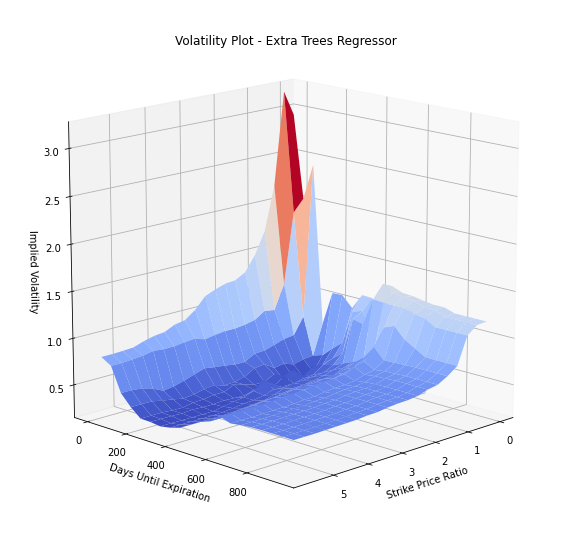

In [ ]:
# Continuation of the above cell
# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_xlabel("Strike Price Ratio")
ax.set_ylabel("Maturity")
ax.set_zlabel("Implied Volatility")
ax.view_init(0, 90)

x_scatter = ([i[0] for i in x_test])[:100]
y_scatter = ([i[1] for i in x_test])[:100]
z_scatter = y_test[:100]
ax.scatter(x_scatter, y_scatter, z_scatter, color="black")
plt.title("Volatility Plot - Extra Trees Regressor")

ax.view_init(15, 45)

# Rotation

#for angle in range(0, 360):
#    ax.view_init(3, angle)
#    plt.draw()
#    plt.pause(.001)


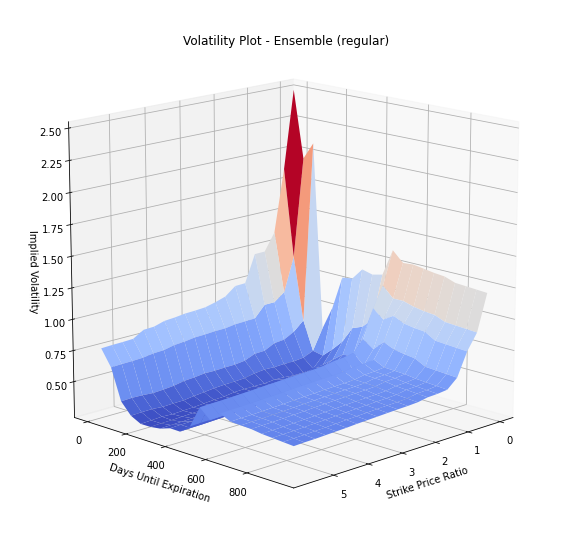

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

sqrt_num_points = 20

X = np.arange(0, 6, 6/sqrt_num_points)
Y = np.arange(0, 1000, 1000/sqrt_num_points)

Z = []
for index_x in range(len(X)):
  allXArray = []
  for index_y in range(len(Y)):
    allXArray += np.array([(ensemble_reg.predict(np.array([[X[index_x], Y[index_y]]]))[0])]).tolist()
  
  Z += [allXArray]

Z = np.array(Z)

X, Y = np.meshgrid(X, Y)


# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_xlabel("Strike Price Ratio")
ax.set_ylabel("Maturity")
ax.set_zlabel("Implied Volatility")
ax.view_init(0, 90)

x_scatter = ([i[0] for i in x_test])[:100]
y_scatter = ([i[1] for i in x_test])[:100]
z_scatter = y_test[:100]
ax.scatter(x_scatter, y_scatter, z_scatter, color="black")
plt.title("Volatility Plot - Ensemble (regular)")

ax.view_init(15, 45)

# Rotation

#for angle in range(0, 360):
#    ax.view_init(3, angle)
#    plt.draw()
#    plt.pause(.001)


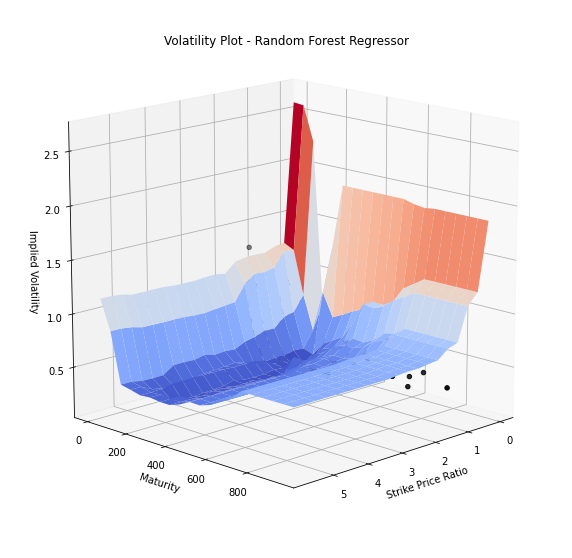

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

sqrt_num_points = 20

X = np.arange(0, 6, 6/sqrt_num_points)
Y = np.arange(0, 1000, 1000/sqrt_num_points)

Z = []
for index_x in range(len(X)):
  allXArray = []
  for index_y in range(len(Y)):
    allXArray += np.array([(random_forest_regressor.predict(np.array([[X[index_x], Y[index_y]]]))[0])]).tolist()
  
  Z += [allXArray]

Z = np.array(Z)

X, Y = np.meshgrid(X, Y)


# Continuation of the above cell
# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_xlabel("Strike Price Ratio")
ax.set_ylabel("Maturity")
ax.set_zlabel("Implied Volatility")
ax.view_init(0, 90)

x_scatter = ([i[0] for i in x_test])[:100]
y_scatter = ([i[1] for i in x_test])[:100]
z_scatter = y_test[:100]
ax.scatter(x_scatter, y_scatter, z_scatter, color="black")
plt.title("Volatility Plot - Random Forest Regressor")

ax.view_init(15, 45)

# Rotation

#for angle in range(0, 360):
#    ax.view_init(3, angle)
#    plt.draw()
#    plt.pause(.001)


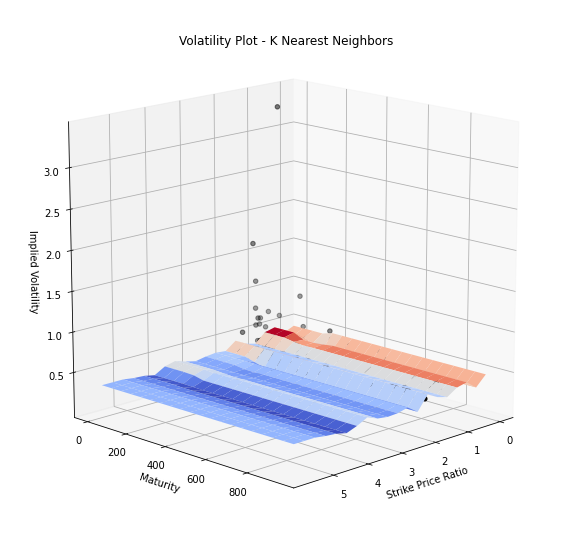

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

sqrt_num_points = 20

X = np.arange(0, 6, 6/sqrt_num_points)
Y = np.arange(0, 1000, 1000/sqrt_num_points)

Z = []
for index_x in range(len(X)):
  allXArray = []
  for index_y in range(len(Y)):
    allXArray += np.array([(knn.predict(np.array([[X[index_x], Y[index_y]]]))[0])]).tolist()
  
  Z += [allXArray]

Z = np.array(Z)

X, Y = np.meshgrid(X, Y)


# Continuation of the above cell
# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_xlabel("Strike Price Ratio")
ax.set_ylabel("Maturity")
ax.set_zlabel("Implied Volatility")
ax.view_init(0, 90)

x_scatter = ([i[0] for i in x_test])[:100]
y_scatter = ([i[1] for i in x_test])[:100]
z_scatter = y_test[:100]
ax.scatter(x_scatter, y_scatter, z_scatter, color="black")
plt.title("Volatility Plot - K Nearest Neighbors")

ax.view_init(15, 45)

# Rotation

#for angle in range(0, 360):
#    ax.view_init(3, angle)
#    plt.draw()
#    plt.pause(.001)


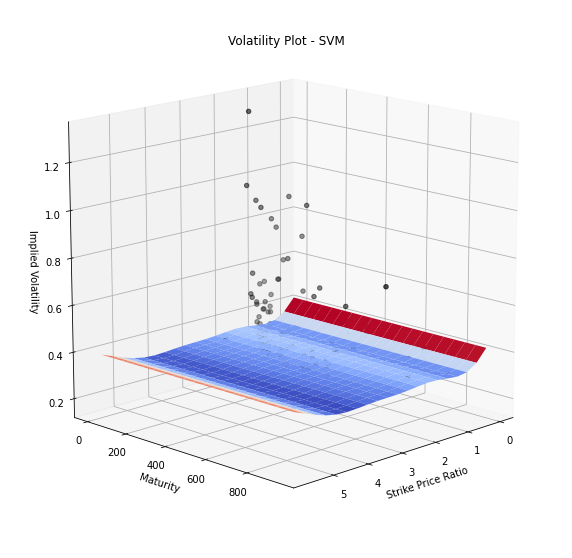

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

sqrt_num_points = 20

X = np.arange(0, 6, 6/sqrt_num_points)
Y = np.arange(0, 1000, 1000/sqrt_num_points)

Z = []
for index_x in range(len(X)):
  allXArray = []
  for index_y in range(len(Y)):
    allXArray += np.array([(svm.predict(np.array([[X[index_x], Y[index_y]]]))[0])]).tolist()
  
  Z += [allXArray]

Z = np.array(Z)

X, Y = np.meshgrid(X, Y)


# Continuation of the above cell
# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_xlabel("Strike Price Ratio")
ax.set_ylabel("Maturity")
ax.set_zlabel("Implied Volatility")
ax.view_init(0, 90)

x_scatter = ([i[0] for i in x_test])[:100]
y_scatter = ([i[1] for i in x_test])[:100]
z_scatter = y_test[:100]
ax.scatter(x_scatter, y_scatter, z_scatter, color="black")
plt.title("Volatility Plot - SVM")

ax.view_init(15, 45)

# Rotation

#for angle in range(0, 360):
#    ax.view_init(3, angle)
#    plt.draw()
#    plt.pause(.001)


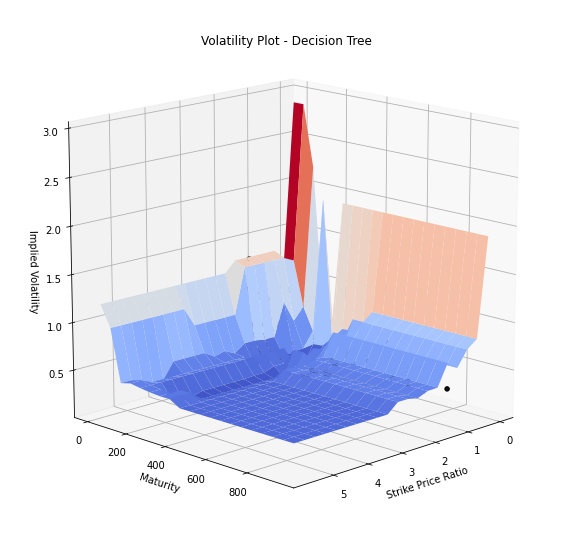

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

sqrt_num_points = 20

X = np.arange(0, 6, 6/sqrt_num_points)
Y = np.arange(0, 1000, 1000/sqrt_num_points)

Z = []
for index_x in range(len(X)):
  allXArray = []
  for index_y in range(len(Y)):
    allXArray += np.array([(decision_tree.predict(np.array([[X[index_x], Y[index_y]]]))[0])]).tolist()
  
  Z += [allXArray]

Z = np.array(Z)

X, Y = np.meshgrid(X, Y)


# Continuation of the above cell
# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_xlabel("Strike Price Ratio")
ax.set_ylabel("Maturity")
ax.set_zlabel("Implied Volatility")
ax.view_init(0, 90)

x_scatter = ([i[0] for i in x_test])[:100]
y_scatter = ([i[1] for i in x_test])[:100]
z_scatter = y_test[:100]
ax.scatter(x_scatter, y_scatter, z_scatter, color="black")
plt.title("Volatility Plot - Decision Tree")

ax.view_init(15, 45)

# Rotation

#for angle in range(0, 360):
#    ax.view_init(3, angle)
#    plt.draw()
#    plt.pause(.001)


1/1 [==============================] - 0s 13ms/step


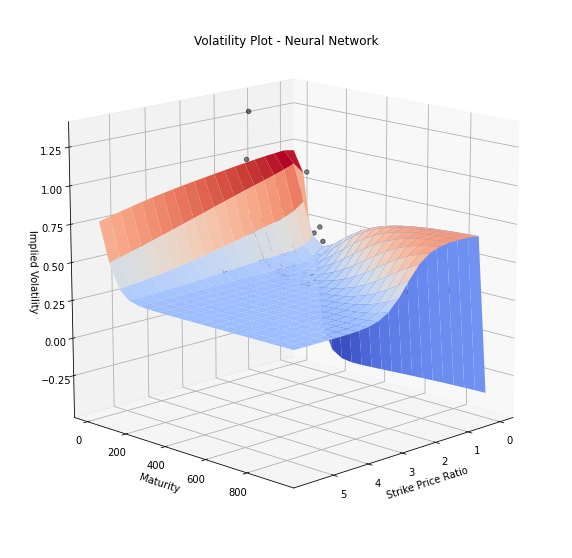

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

sqrt_num_points = 20

X = np.arange(0, 6, 6/sqrt_num_points)
Y = np.arange(0, 1000, 1000/sqrt_num_points)

Z = []
for index_x in range(len(X)):
  allXArray = []
  for index_y in range(len(Y)):
    allXArray += (nn.predict(np.array([[X[index_x], Y[index_y]]]))[0]).tolist()
  
  Z += [allXArray]

Z = np.array(Z)

X, Y = np.meshgrid(X, Y)


# Continuation of the above cell
# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_xlabel("Strike Price Ratio")
ax.set_ylabel("Maturity")
ax.set_zlabel("Implied Volatility")
ax.view_init(0, 90)

x_scatter = ([i[0] for i in x_test])[:100]
y_scatter = ([i[1] for i in x_test])[:100]
z_scatter = y_test[:100]
ax.scatter(x_scatter, y_scatter, z_scatter, color="black")
plt.title("Volatility Plot - Neural Network")

ax.view_init(15, 45)

# Rotation

#for angle in range(0, 360):
#    ax.view_init(3, angle)
#    plt.draw()
#    plt.pause(.001)


1.0 [0.12382685 0.15925791 0.12222626 0.13244816 0.14250637 0.15698436
 0.16275009]
1/1 [==============================] - 0s 15ms/step
1.0 [0.12382685 0.15925791 0.12222626 0.13244816 0.14250637 0.15698436
 0.16275009]
1/1 [==============================] - 0s 16ms/step
1.0 [0.12382685 0.15925791 0.12222626 0.13244816 0.14250637 0.15698436
 0.16275009]
1/1 [==============================] - 0s 17ms/step
1.0 [0.12382685 0.15925791 0.12222626 0.13244816 0.14250637 0.15698436
 0.16275009]
1/1 [==============================] - 0s 19ms/step
1.0 [0.12382685 0.15925791 0.12222626 0.13244816 0.14250637 0.15698436
 0.16275009]
1/1 [==============================] - 0s 17ms/step
1.0 [0.12382685 0.15925791 0.12222626 0.13244816 0.14250637 0.15698436
 0.16275009]
1/1 [==============================] - 0s 15ms/step
1.0 [0.12382685 0.15925791 0.12222626 0.13244816 0.14250637 0.15698436
 0.16275009]
1/1 [==============================] - 0s 14ms/step
1.0 [0.12382685 0.15925791 0.12222626 0.13244816

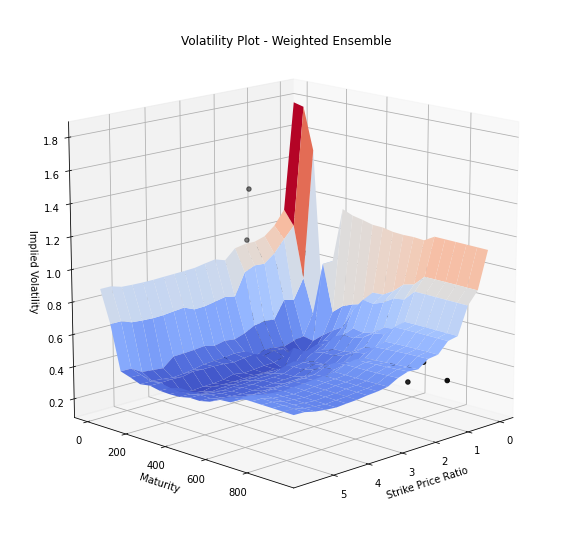

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

sqrt_num_points = 20

X = np.arange(0, 6, 6/sqrt_num_points)
Y = np.arange(0, 1000, 1000/sqrt_num_points)

Z = []
for index_x in range(len(X)):
  allXArray = []
  for index_y in range(len(Y)):
    allXArray += np.array([(get_ensemble_pred(np.array([[X[index_x], Y[index_y]]]))[0])]).tolist()
    
  Z += [allXArray]

Z = np.array(Z)

X, Y = np.meshgrid(X, Y)


# Continuation of the above cell
# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_xlabel("Strike Price Ratio")
ax.set_ylabel("Maturity")
ax.set_zlabel("Implied Volatility")
ax.view_init(0, 90)

x_scatter = ([i[0] for i in x_test])[:100]
y_scatter = ([i[1] for i in x_test])[:100]
z_scatter = y_test[:100]
ax.scatter(x_scatter, y_scatter, z_scatter, color="black")
plt.title("Volatility Plot - Weighted Ensemble")

ax.view_init(15, 45)

# Rotation

#for angle in range(0, 360):
#    ax.view_init(3, angle)
#    plt.draw()
#    plt.pause(.001)


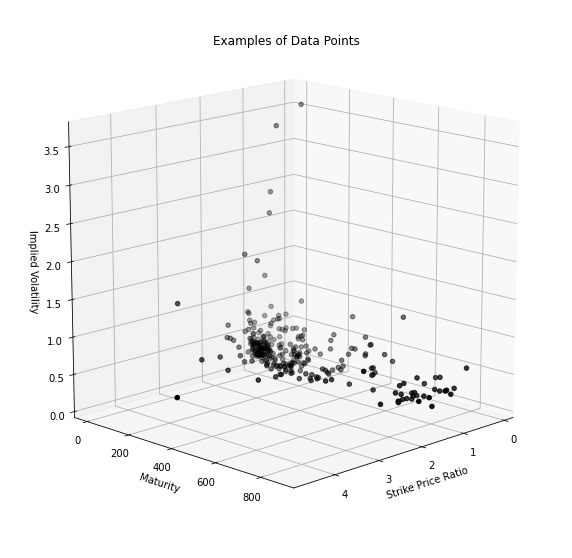

In [ ]:
# Scatterplot for Reference

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))

ax.set_xlabel("Strike Price Ratio")
ax.set_ylabel("Days Until Expiration")
ax.set_zlabel("Implied Volatility")
ax.view_init(0, 90)

x_scatter = ([i[0] for i in x_test])[:300]
y_scatter = ([i[1] for i in x_test])[:300]
z_scatter = y_test[:300]
ax.scatter(x_scatter, y_scatter, z_scatter, color="black")
plt.title("Examples of Data Points")

ax.view_init(15, 45)